# versionをまたいだ，学習データなどの分析を行う総合分析ノートブック


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数
import warnings

#自作のモジュールのインポート
sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


In [2]:
def get_season_date(now_date):#日付(datetime型)を渡すと，その日付で購買予測を行う際に使用するデータの区間を返す関数
    use_data_year=now_date.year
    if (now_date.month>=1)and(now_date.month<4):
        use_data_month=1
    elif (now_date.month>=4)and(now_date.month<7):
        use_data_month=4
    elif (now_date.month>=7)and(now_date.month<10):
        use_data_month=7
    elif (now_date.month>=10):
        use_data_month=10
    else:
        print('what???????')
    use_data_date=datetime.datetime(year=use_data_year, month=use_data_month,day=1)
    return use_data_date


def get_4_section_dt(now_date):#今いる区間から直近4区間の開始日をリストで返してくれる関数
    now_sec_date=get_season_date(now_date)
    diff_sec_stdates=[0]*4
    for i in range(len(diff_sec_stdates)):
        diff_sec_stdates[3-i]=now_sec_date- relativedelta(months=3*(i+1))#古い順に日付を入れていく
    return diff_sec_stdates

def get_feature_weights(score_final_df):#相関係数を変数の重みとして取得する関数，（1comあたり1行のdfを返す．）(引数として一つ前の区間,もしくは昨年同月区間のfinalありスコアのdfを渡す)
    plus_m_th=1
    num_hit_th=3
    feature_weights_df=pd.DataFrame()
    for com in sorted(score_final_df['target_com'].value_counts().sort_index().index):
        target_com_df=score_final_df[score_final_df['target_com']==com]
        #ざっと切り捨て，あまりに少ないのは適さないと思うので消す
        target_com_df=target_com_df[target_com_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
        target_com_df=target_com_df[target_com_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
        target_com_corr=target_com_df.corr()
        target_com_weights=target_com_corr.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ        
        feature_weights_df=feature_weights_df.append(target_com_weights)
    feature_weights_df['target_com']=score_final_df['target_com'].value_counts().sort_index().index
    feature_weights_df=feature_weights_df.set_index('target_com')
    feature_weights_df=feature_weights_df.fillna(0)
    return feature_weights_df


def add_std_score(good_model_df,feature_weights):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().sort_index().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        #display(feature_weights)
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df

def add_std_score_DFversion(good_model_df,feature_weights_df):#偏差値と相関係数をもとにしたスコアを与える
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().sort_index().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        feature_weights=feature_weights_df.loc[com].copy()
        #display(feature_weights)
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df


def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n, marker="o")
    ax1.tick_params()
    plt.ylim(80, 200)
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red', marker="*")
    ax1.axhline(100,ls = "-.",color='green')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

In [73]:
#分析系
def get_num_plus_model_com(score_df):#スコアシートを渡して，プラスだったモデルの数と，comの数と割合を返してくる(series)関数
    analysis_s=pd.Series(dtype='object')
    analysis_s['num_plus_model']=len(score_df[score_df['gain_final']>105])
    analysis_s['plus_model_per']=(len(score_df[score_df['gain_final']>105])/len(score_df))*100
    analysis_s['num_plus_com']=len(score_df[score_df['gain_final']>105]['target_com'].value_counts().index)
    analysis_s['plus_com_per']=(len(score_df[score_df['gain_final']>105]['target_com'].value_counts().index)/len(score_df['target_com'].value_counts().index))*100
    return analysis_s

def get_num_both_plus_model_com(score_df):#スコアシートを渡して，test finalともにプラスだったモデルの数と，comの数と割合を返してくる(series)関数
    analysis_s=pd.Series(dtype='object')
    analysis_s['num_plus_model']=len(score_df[(score_df["gain_test"]>105) & (score_df['gain_final']>105)])
    analysis_s['plus_model_per']=(len(score_df[(score_df["gain_test"]>105) & (score_df['gain_final']>105)])/len(score_df))*100
    analysis_s['num_plus_com']=len(score_df[(score_df["gain_test"]>105) & (score_df['gain_final']>105)]['target_com'].value_counts().index)
    analysis_s['plus_com_per']=(len(score_df[(score_df["gain_test"]>105) & (score_df['gain_final']>105)]['target_com'].value_counts().index)/len(score_df['target_com'].value_counts().index))*100
    return analysis_s

def get_num_test_plus_model_com(score_df):#スコアシートを渡して，プラスだったモデルの数と，comの数と割合を返してくる(series)関数
    analysis_s=pd.Series(dtype='object')
    analysis_s['num_plus_model']=len(score_df[score_df['gain_test']>105])
    analysis_s['plus_model_per']=(len(score_df[score_df['gain_test']>105])/len(score_df))*100
    analysis_s['num_plus_com']=len(score_df[score_df['gain_test']>105]['target_com'].value_counts().index)
    analysis_s['plus_com_per']=(len(score_df[score_df['gain_test']>105]['target_com'].value_counts().index)/len(score_df['target_com'].value_counts().index))*100
    return analysis_s

def serch_group(models_df):#モデルシートのパラメータをもとに，パラメータが連続している範囲内で同じ集団とし，集団番号を与える関数
    add_number_df=models_df.copy()
    add_number_df["group_num"]=0
    g_num=0
    g_num_arr=[0]*len(add_number_df)
    diff_index=-1
    i=0
    for index,row in add_number_df.iterrows():
        if index==diff_index+1:
            g_num_arr[i]=g_num
            diff_index=index#現在のインデックスを一つ前として保存
        elif index>diff_index+1:
            g_num=1+g_num
            g_num_arr[i]=g_num
            diff_index=index#現在のインデックスを一つ前として保存
        else:
            print('???????????????????????????????????')
        i+=1
    add_number_df["group_num"]=g_num_arr
    return add_number_df


def get_same_para_model(selected_model_df,now_year_score_df):
    use_models_df=pd.DataFrame()
    for index,row in selected_model_df.iterrows():
        target_df=now_year_score_df[now_year_score_df["target_com"]==row['target_com']].copy()
        target_df=target_df[target_df['threshold']==row['threshold']].copy()
        target_df=target_df[target_df['depth']==row['depth']].copy()
        target_df=target_df[target_df['target_per']==row['target_per']].copy()
        use_models_df=pd.concat([use_models_df,target_df])
    return use_models_df


#可視化系
def df_twin_plt(df,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    x=df[x_n].values
    y1=df[y1_n].values
    y2=df[y2_n].values
    
    ax1 = fig.add_subplot()
    ax1.plot(x, y1,label=y1_n, marker="o")
    ax1.tick_params()
    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red', marker="*")
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2)

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None
def df_bar_twin_plt(df,x_n,y1_n,y2_n):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    x=df[x_n].values
    y1=df[y1_n].values
    y2=df[y2_n].values
    color = [('b' if i > 0 else 'r') for i in y1]
    plt.xticks(x)#x軸をカテゴリで表示
    
    ax1 = fig.add_subplot()
    ax1.bar(x, y1,label=y1_n,color=color)
    ax1.tick_params()
    ax2 = ax1.twinx()
    ax2.plot(x, y2,label=y2_n,color='green', marker="*")
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2)
    
    
    ax1.axhline(y=0,color='black')#水平の基準線を引く
    ax1.grid(axis='x')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None
def df_hist_plt(df,target_col,num_bin=50,ylims=None):#2本軸でのグラフの描写
    #ylims:縦軸の範囲をセットする引数
    target_vals=df[target_col].values
    
    #グラフの処理
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    ax = fig.add_subplot()
    ax.hist(target_vals, bins=num_bin)
    ax.set_title(target_col)
    ax.set_xlabel('step')
    ax.set_ylabel('num_values')
    if ylims!=None:
        ax.set_ylim(ylims[0],ylims[1])
    plt.show()
    return None

def df_hist_cate_plt(df,target_col,ylims=None,plt_ti=None,xlabel=None,ylabel=None):#2本軸でのグラフの描写,xにカテゴリカルなものがくる場合に使用
    #ylims:縦軸の範囲をセットする引数
    target_vals=df[target_col].values
    x=np.arange(1,len(target_vals)+1)

    #グラフの処理
    fig, ax=  plt.subplots(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    color = [('b' if i > 0 else 'r') for i in target_vals]
    plt.grid()
    
    plt.bar(x,target_vals,color=color)
    plt.xticks(x,df.index.values)#x軸をカテゴリで表示
    plt.axhline(y=0,color='black')#水平の基準線を引く
    ax.set_xlabel("index")
    ax.set_ylabel('num')
    if ylims!=None:
        ax.set_ylim(ylims[0],ylims[1])
    if xlabel!=None:
        ax.set_xlabel(xlabel)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
    if plt_ti!=None:
        ax.set_title(plt_ti)
    
    plt.show()
    return None

def df_triple_plt(df,x_n,y1_1_n,y1_2_n,y2_1_n,y2_2_n):#3本軸でのグラフの描写(y1 一軸，y2_1.y2_2で二軸で計３軸,本数は4本)
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    x=df[x_n].values
    y1_1=df[y1_1_n].values
    y1_2=df[y1_2_n].values
    
    y2_1=df[y2_1_n].values
    y2_2=df[y2_2_n].values
    
    ax1 = fig.add_subplot()
    ax1.plot(x, y1_1,label=y1_1_n,color='orange', marker="o")
    ax1.plot(x, y1_2,label=y1_2_n,color='red', marker="o")
    #ax1.tick_params()
    
    ax2 = ax1.twinx()#右側の軸（一本目）の生成
    ax2.plot(x, y2_1,label=y2_1_n,color='blue', marker="*")
    ax2.tick_params()
    
    ax3 = ax1.twinx()#右側の軸（２本目）の生成
    ax3.plot(x, y2_2,label=y2_2_n,color='skyblue', marker="*")
    ax3.tick_params()

    plt.xticks(color="None")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    h3, l3 = ax3.get_legend_handles_labels()
    ax1.legend(h1+h2+h3, l1+l2+l3)
    ax1.set_xlabel(x_n)
    ax1.set_ylabel("[{} , {}]".format(y1_1_n,y1_2_n))
    ax2.set_ylabel(y2_1_n)
    ax3.set_ylabel(y2_2_n)
    ax3.spines["right"].set_position(("axes", 1.08))
    plt.show()
    return None

In [4]:
place_master=master.get_place_master()
place_names=[place_name for place_name in place_master.values()]#会場名のみを収納した配列

## 超絶基礎集計

### 長い区間で会場ごとのcomの出現に関する集計を行い，年ごとの分布を確認する

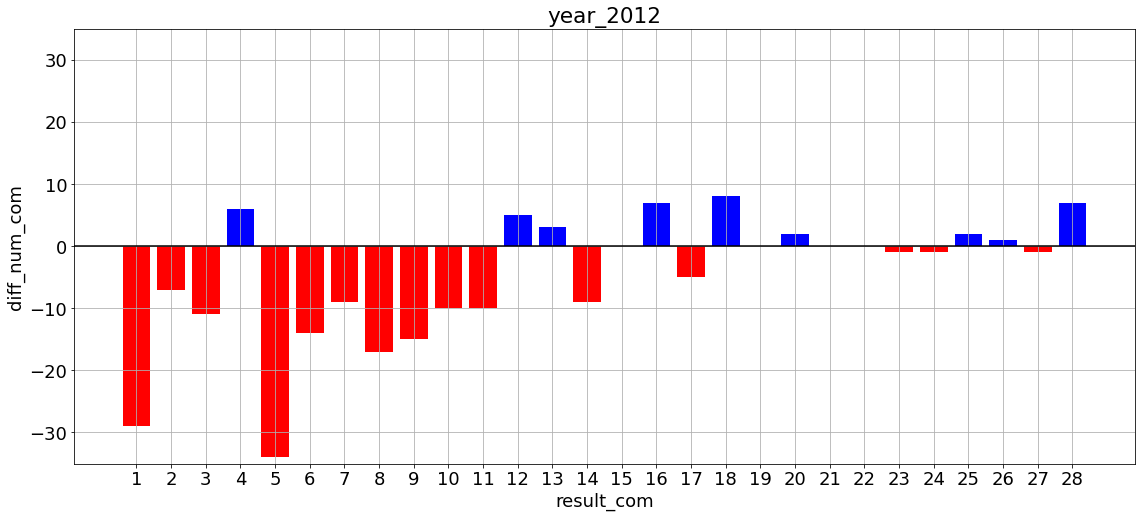

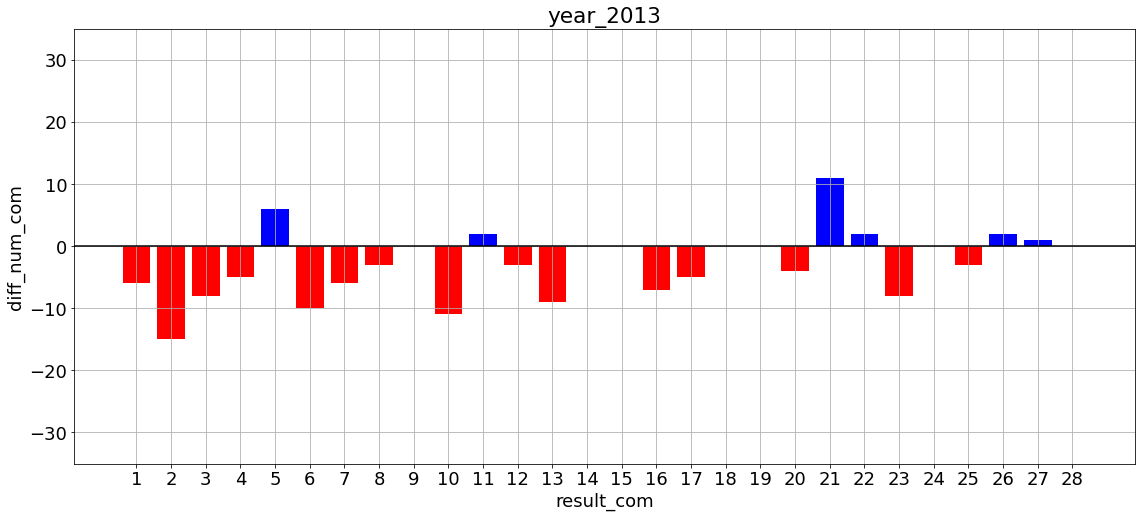

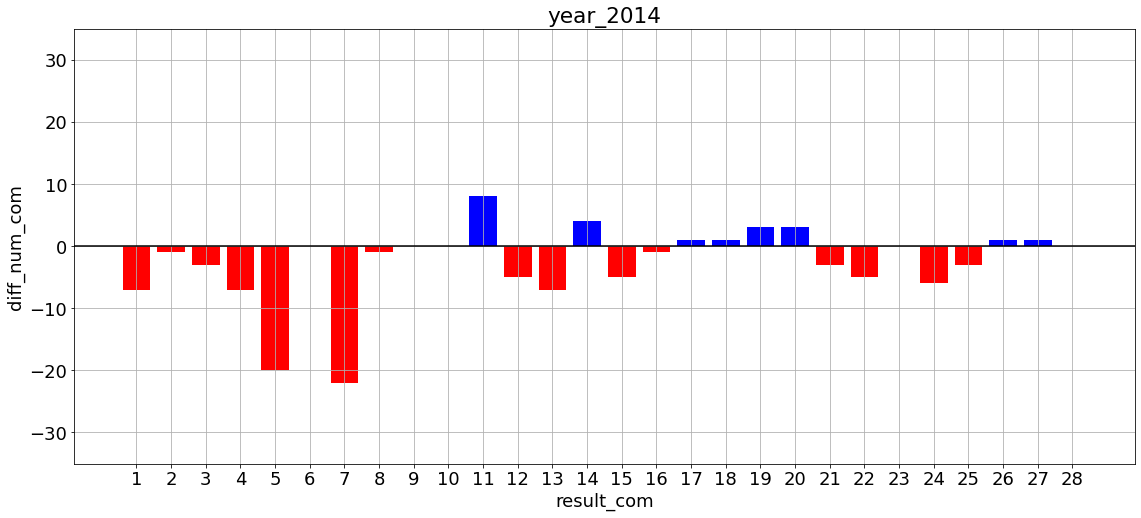

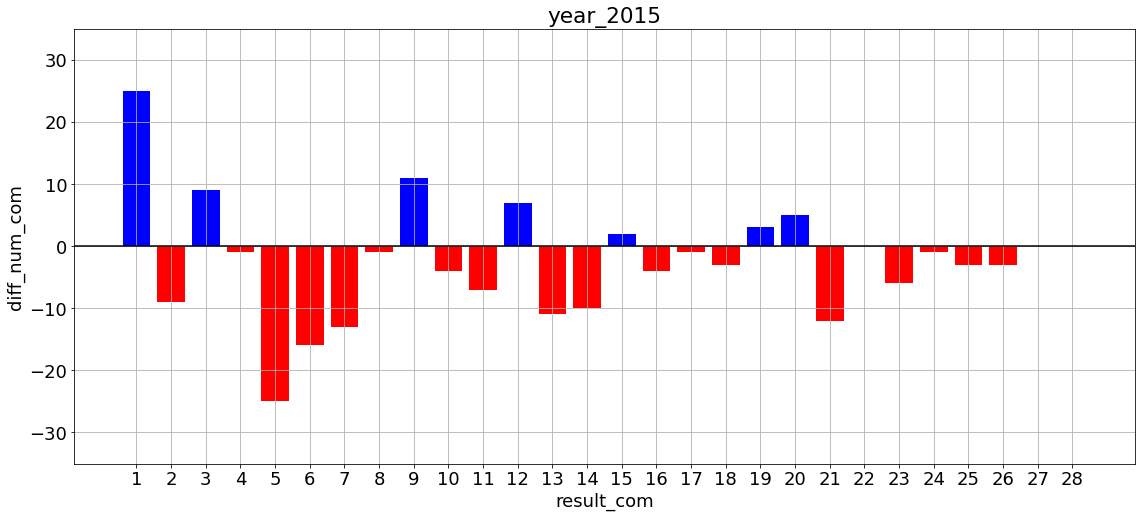

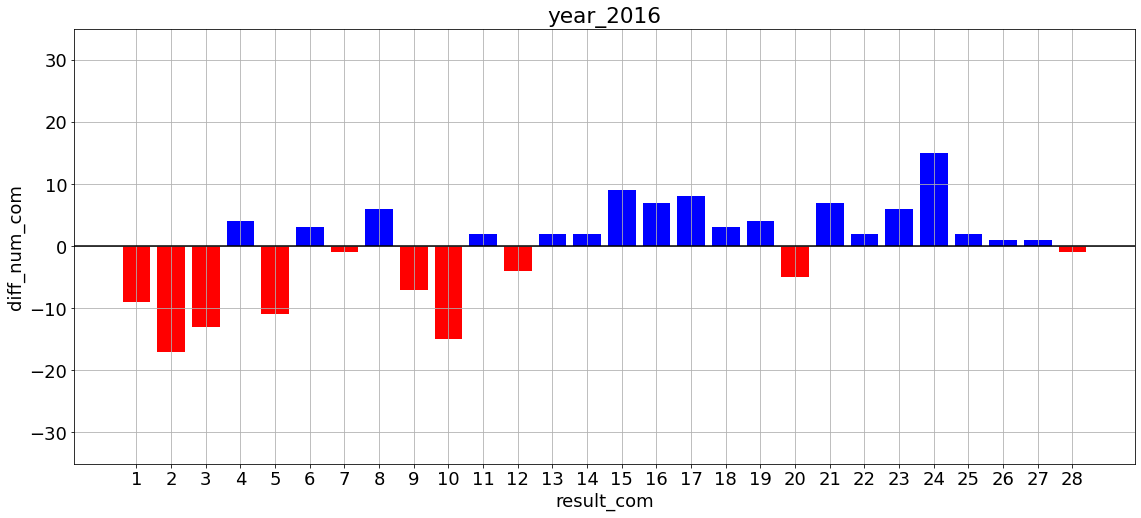

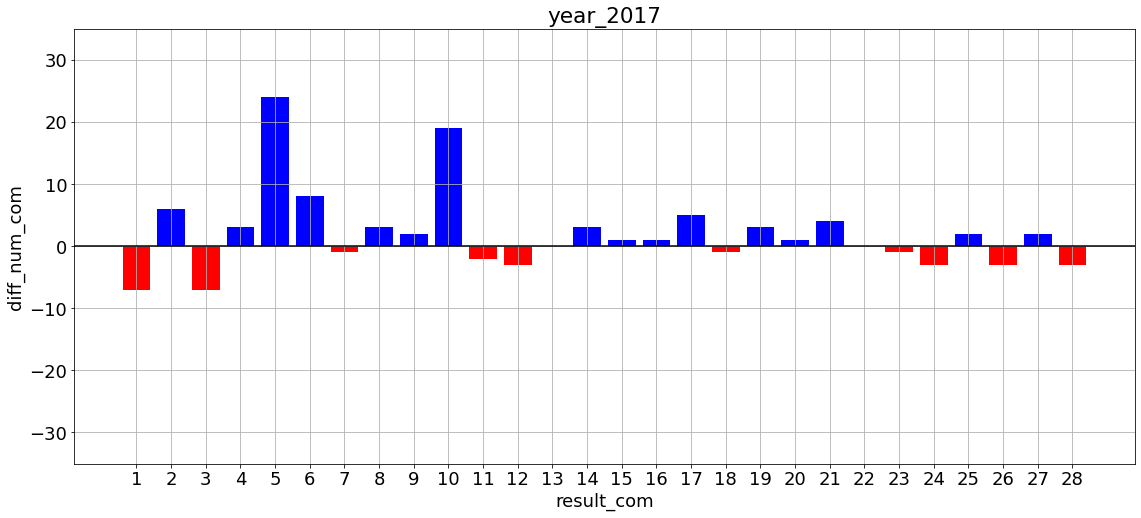

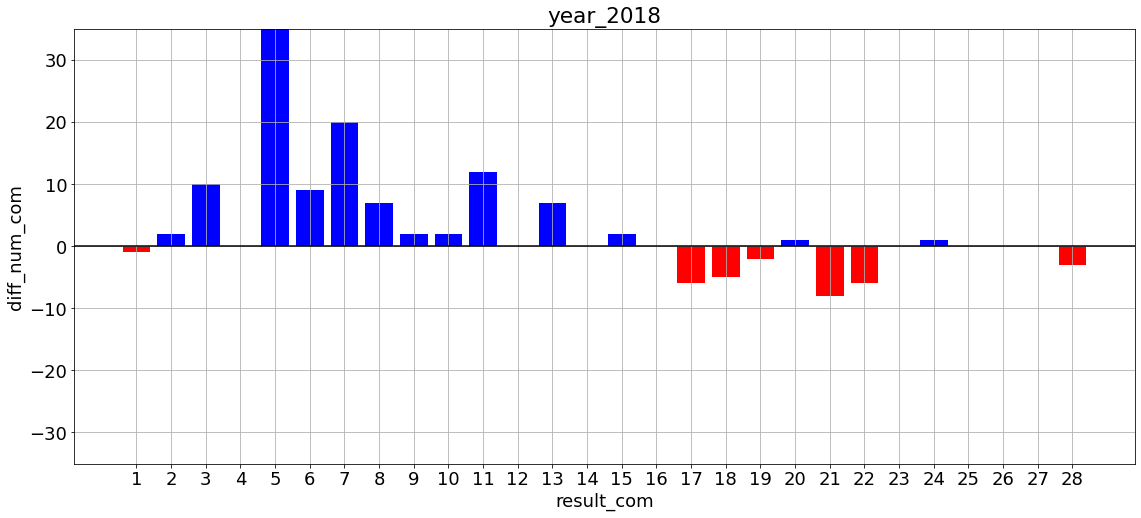

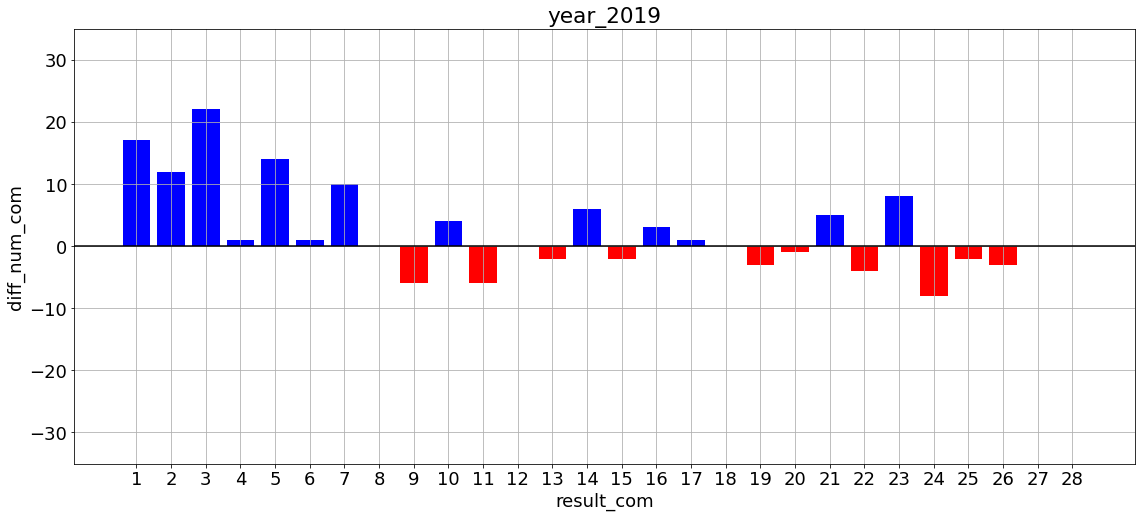

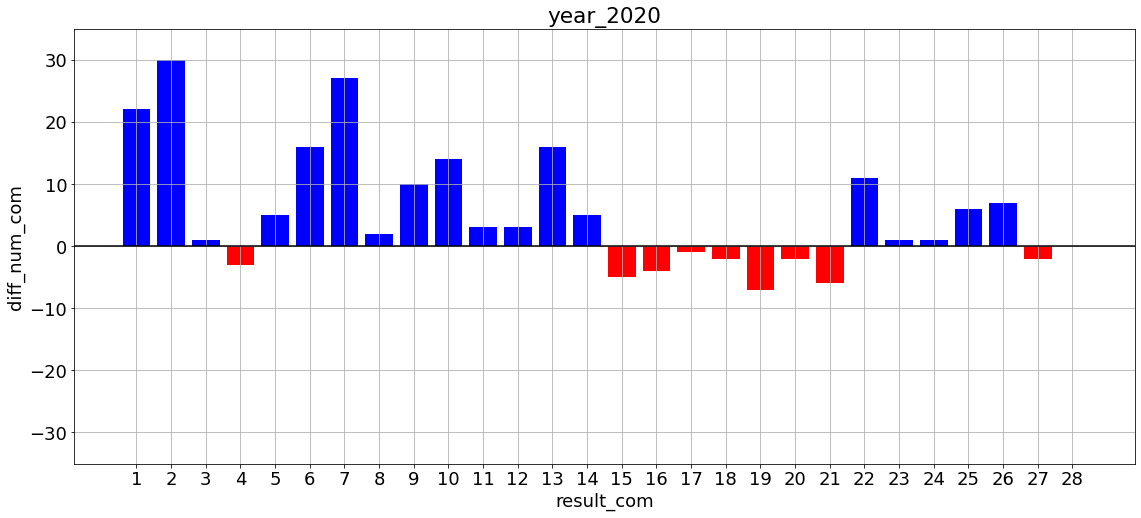

In [15]:
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv'.format(place_name=place_name)
train_df=pd.read_csv(dir_path, encoding='utf_8_sig')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
train_df=train_df[train_df['result_com']<=28].copy()#どうせ見ないレースは消す
train_df['date']=pd.to_datetime(train_df['date'])#日付が文字列なのでdateを日付型に変換
train_df['year']=train_df['date'].dt.year
train_df=train_df[train_df['year']!=2021]

#年を行に，comを列にした分析用のdfを作る.
num_com_df=pd.DataFrame(columns=np.arange(1,29),dtype=int)
years_arr=sorted(train_df['year'].value_counts().index)
for year in years_arr:
    target_df=train_df[train_df['year']==year].copy()
    
    com_count=target_df['result_com'].value_counts(sort=False)
    year_s=pd.Series(index=np.arange(1,29),data=com_count.values,dtype=int)
    num_com_df.loc[year]=year_s
num_com_desc_df=num_com_df.describe()
diff_num_com_df=num_com_df.copy()

#desc_dfの統計量との差を確認する(mean)
for index,row in num_com_df.iterrows():
    for key,val in row.items():
        diff_num_com_df.at[index,key]=diff_num_com_df.at[index,key]-num_com_desc_df.at['mean',key]
        

num_com_desc_df_2019_2020=num_com_df.loc[:2018].describe()#2019,2020を除いた党警鐘を算出
diff_num_com_df_2019_2020=num_com_df.copy()
#2019,2020を除いた，desc_dfの統計量との差を確認する(mean)
for index,row in diff_num_com_df_2019_2020.iterrows():
    for key,val in row.items():
        diff_num_com_df_2019_2020.at[index,key]=diff_num_com_df_2019_2020.at[index,key]-num_com_desc_df_2019_2020.at['mean',key]
        
diff_num_com_trans_df=diff_num_com_df.transpose()#マットプロット用，行と列を入れ替えた
diff_num_com_trans_df_2019_2020=diff_num_com_df_2019_2020.transpose()#マットプロット用，行と列を入れ替えた\

#num_com_df:年ごとの出現数をまとめたdf
#num_com_desc_df:全体を通しての統計量を持ったdf


#以下グラフの描画
for col in diff_num_com_trans_df.columns:
    #if col==2020 or col==2019:
    df_hist_cate_plt(diff_num_com_trans_df,col,ylims=[-35,35],plt_ti="year_"+str(col),xlabel="result_com",ylabel="diff_num_com")

# #以下グラフの描画
# for col in diff_num_com_trans_df_2019_2020.columns:
#     if col==2020:
#         df_hist_cate_plt(diff_num_com_trans_df_2019_2020,col,plt_ti="year_"+str(index))

In [18]:
num_com_df.to_csv('csv/asiya_num_com_master.csv')

### 絶対的な出現数ではなく，割合に変更したもの

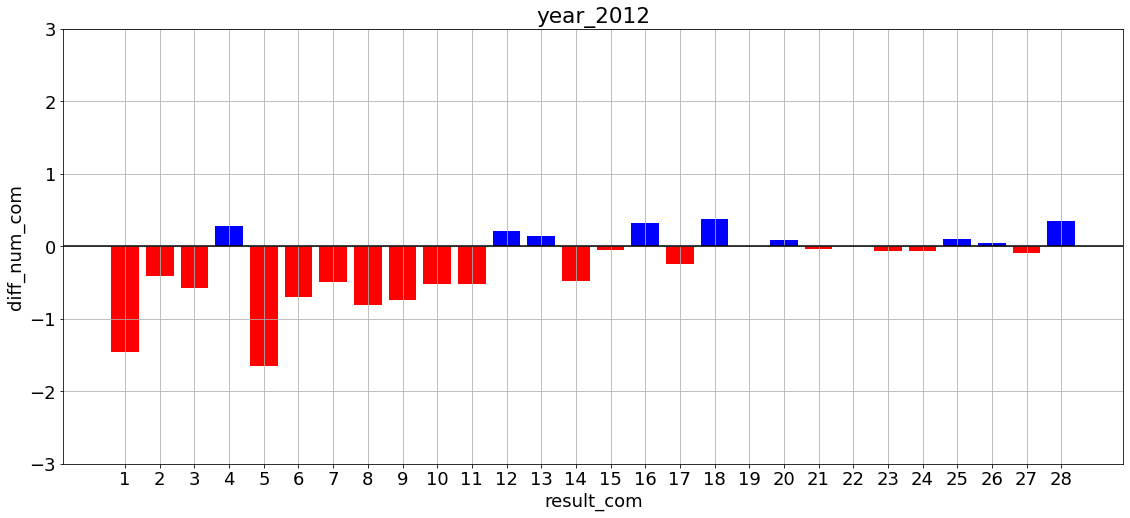

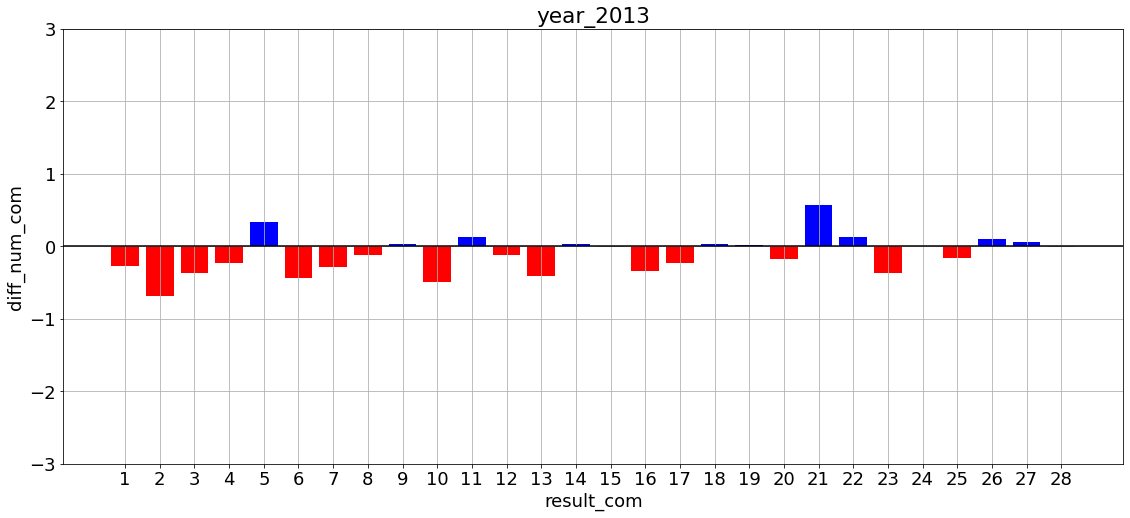

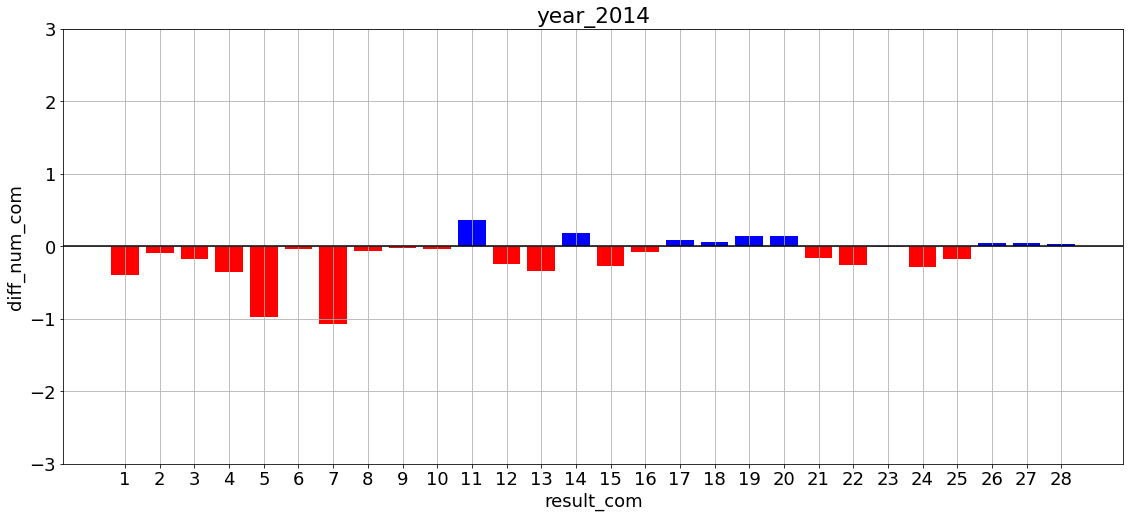

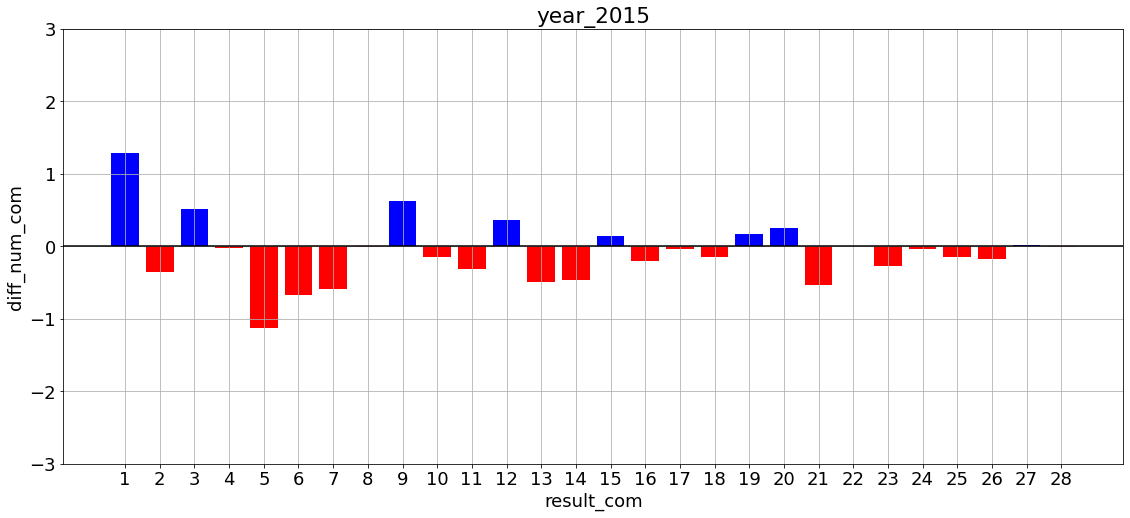

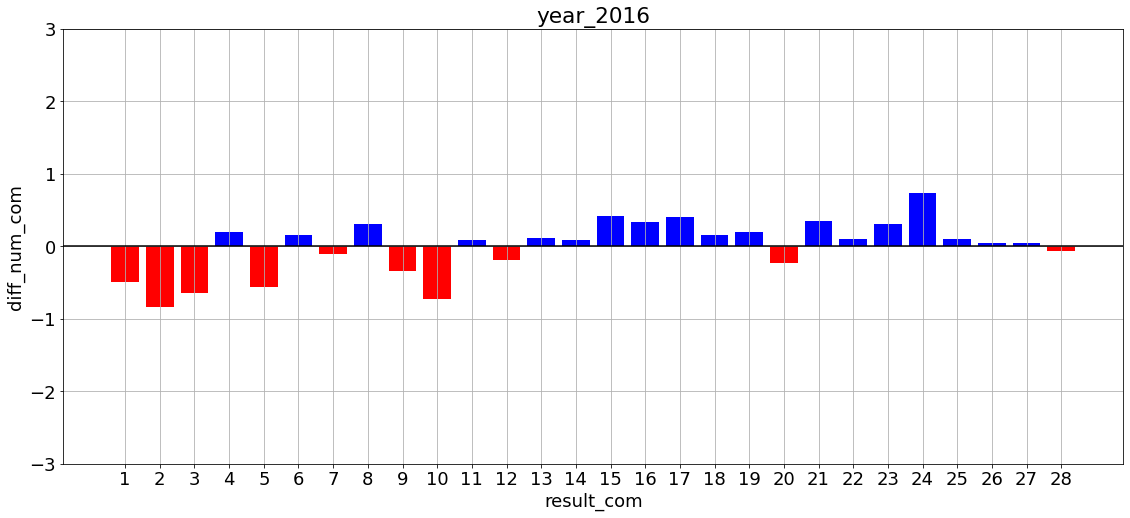

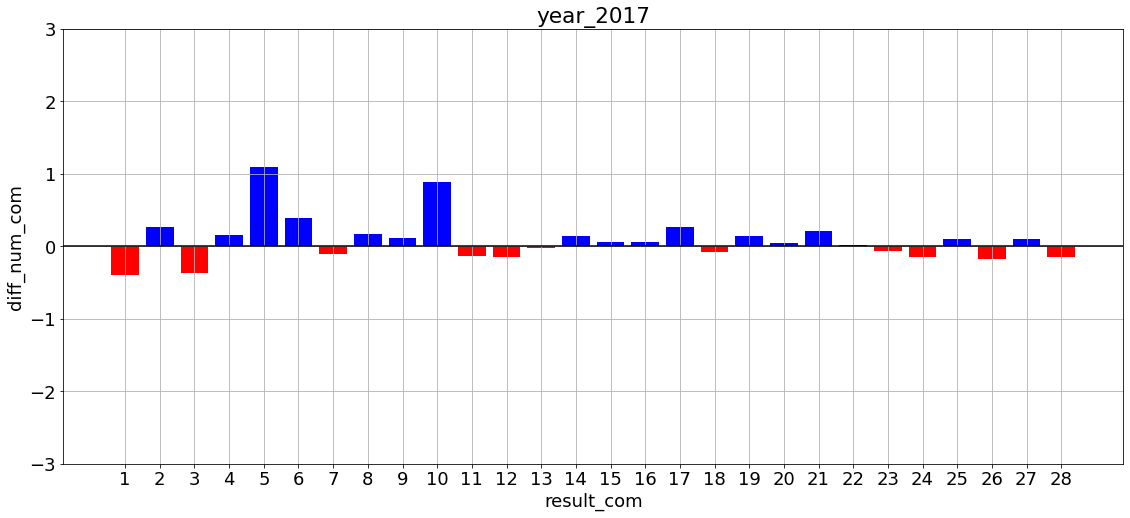

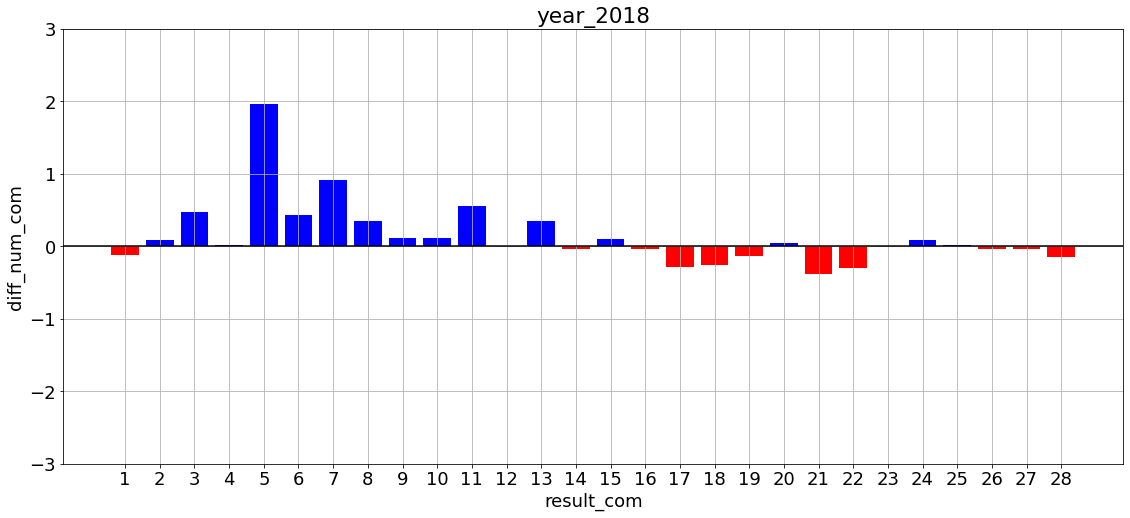

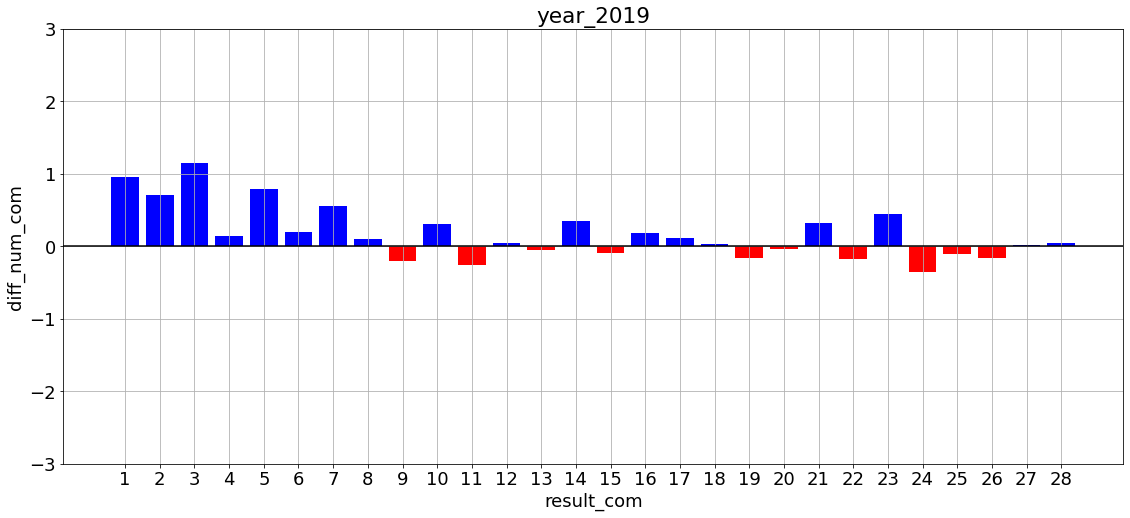

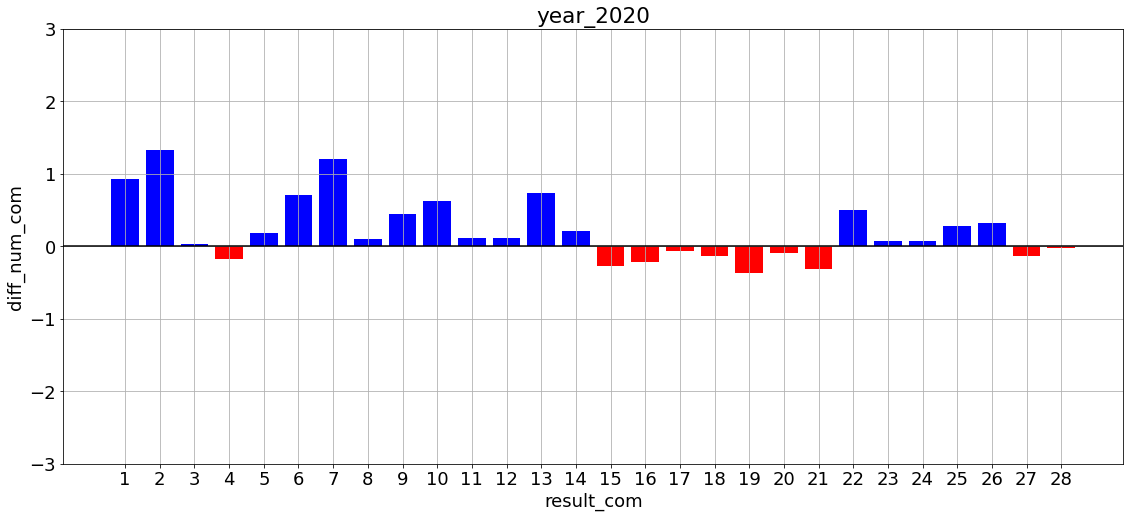

In [10]:
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv'.format(place_name=place_name)
train_df=pd.read_csv(dir_path, encoding='utf_8_sig')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
train_df['date']=pd.to_datetime(train_df['date'])#日付が文字列なのでdateを日付型に変換
train_df['year']=train_df['date'].dt.year
train_df=train_df[train_df['year']!=2021]
num_races=train_df.value_counts('year',sort=False).values#年が古い順にする
train_df=train_df[train_df['result_com']<=28].copy()#どうせ見ないレースは消す


#年を行に，comを列にした分析用のdfを作る.
num_com_df=pd.DataFrame(columns=np.arange(1,29),dtype=int)
years_arr=sorted(train_df['year'].value_counts().index)
for year,num_year_race in zip(years_arr,num_races):
    target_df=train_df[train_df['year']==year].copy()
    
    com_count=target_df['result_com'].value_counts(sort=False)
    year_s=pd.Series(index=np.arange(1,29),data=com_count.values,dtype=int)
    year_s=(year_s/num_year_race)*100
    num_com_df.loc[year]=year_s
num_com_desc_df=num_com_df.describe()
diff_num_com_df=num_com_df.copy()

#desc_dfの統計量との差を確認する(mean)
for index,row in num_com_df.iterrows():
    for key,val in row.items():
        diff_num_com_df.at[index,key]=diff_num_com_df.at[index,key]-num_com_desc_df.at['mean',key]

#num_com_df:年ごとの出現数をまとめたdf
#num_com_desc_df:全体を通しての統計量を持ったdf
diff_num_com_trans_df=diff_num_com_df.transpose()#マットプロット用，行と列を入れ替えた

#以下グラフの描画
for col in diff_num_com_trans_df.columns:
    #if col==2020 or col==2019:
    df_hist_cate_plt(diff_num_com_trans_df,col,ylims=[-3,3],plt_ti="year_"+str(col),xlabel="result_com",ylabel="diff_num_com")



# 出現数と同じような感じで，配当金額についても分析を行う（配当金マスタを作成）

2012
2013
2014
2015
2016
2017
2018
2019
2020


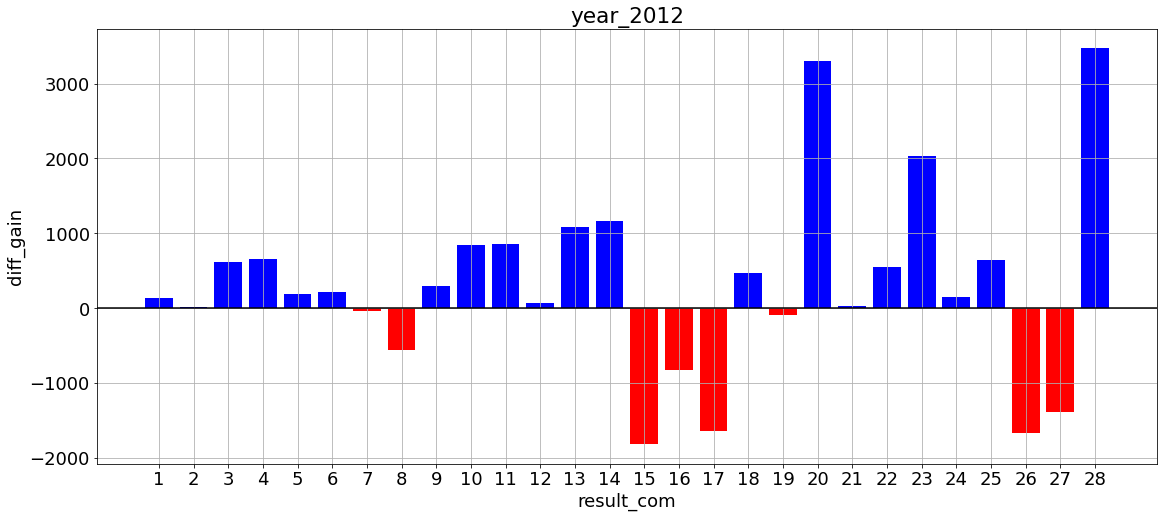

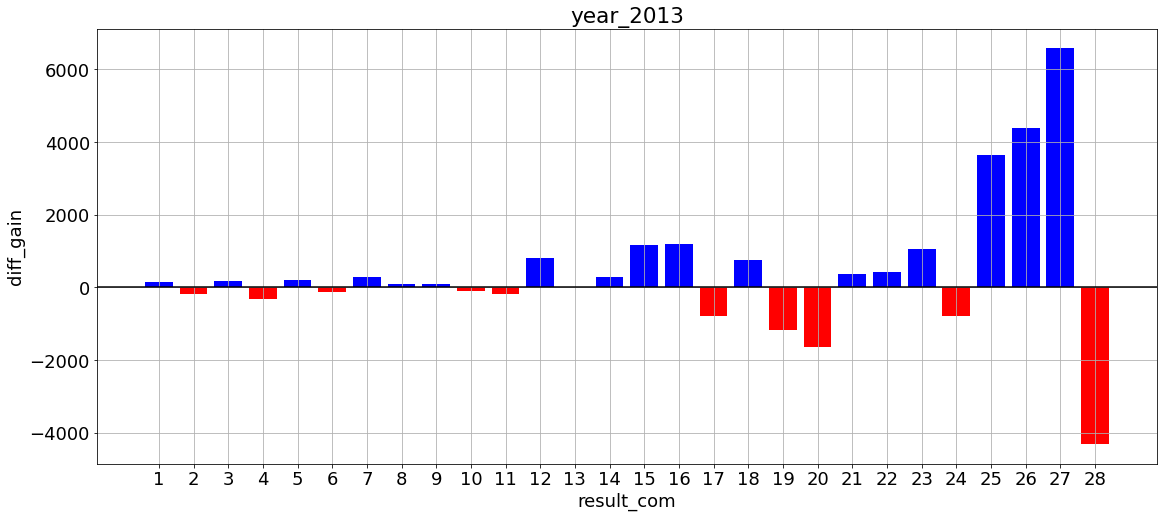

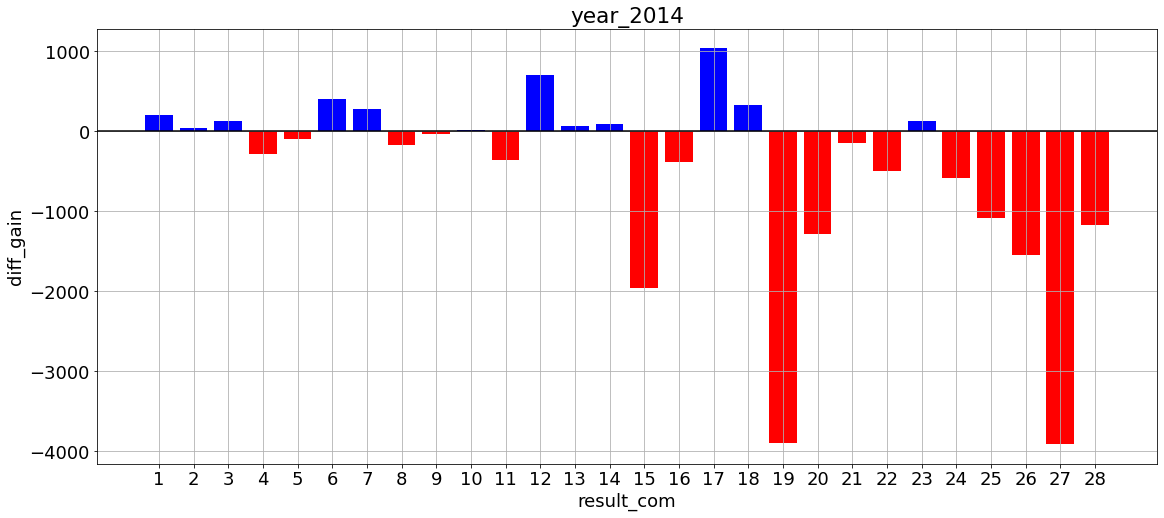

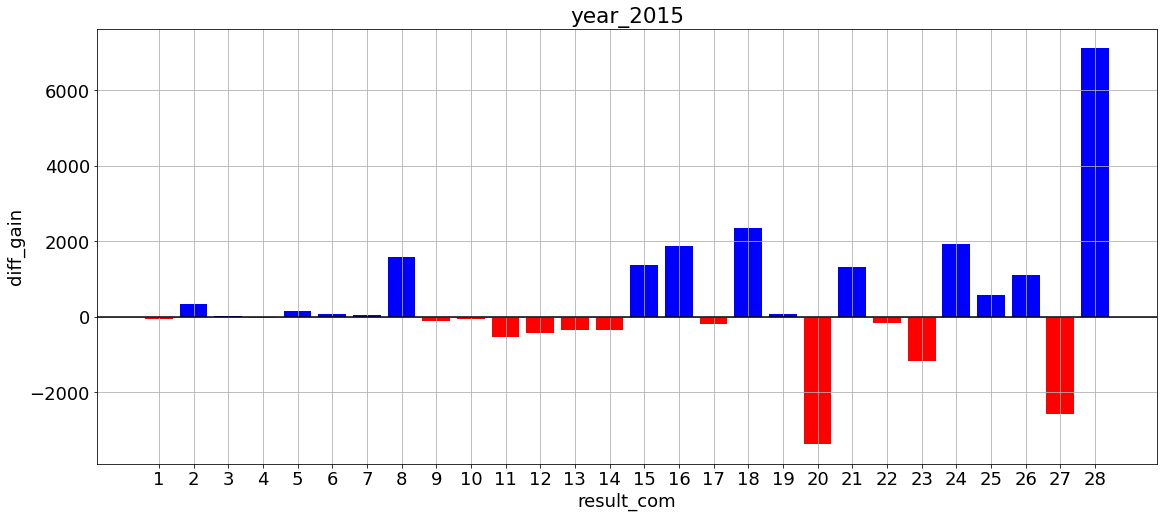

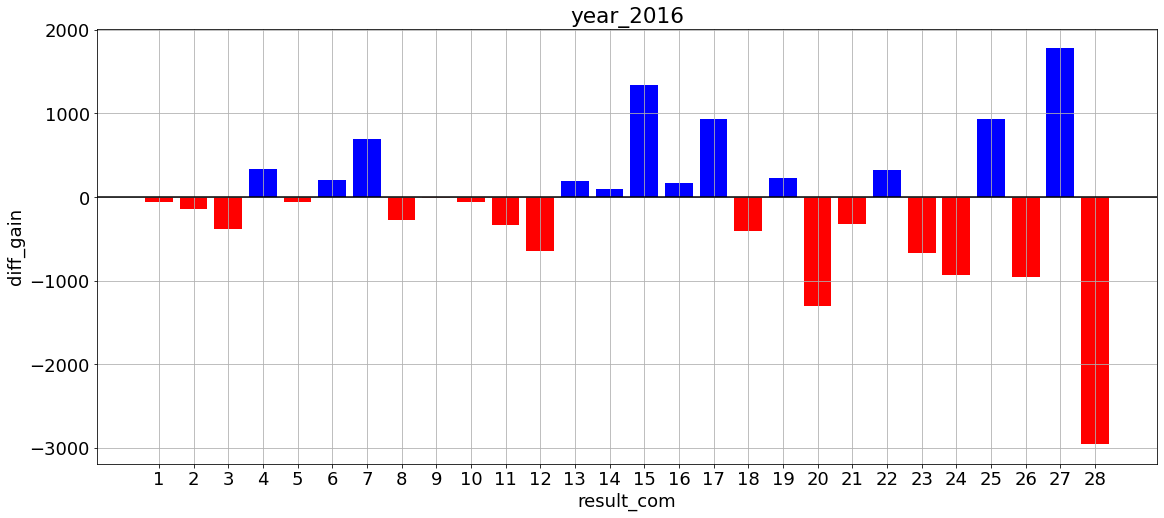

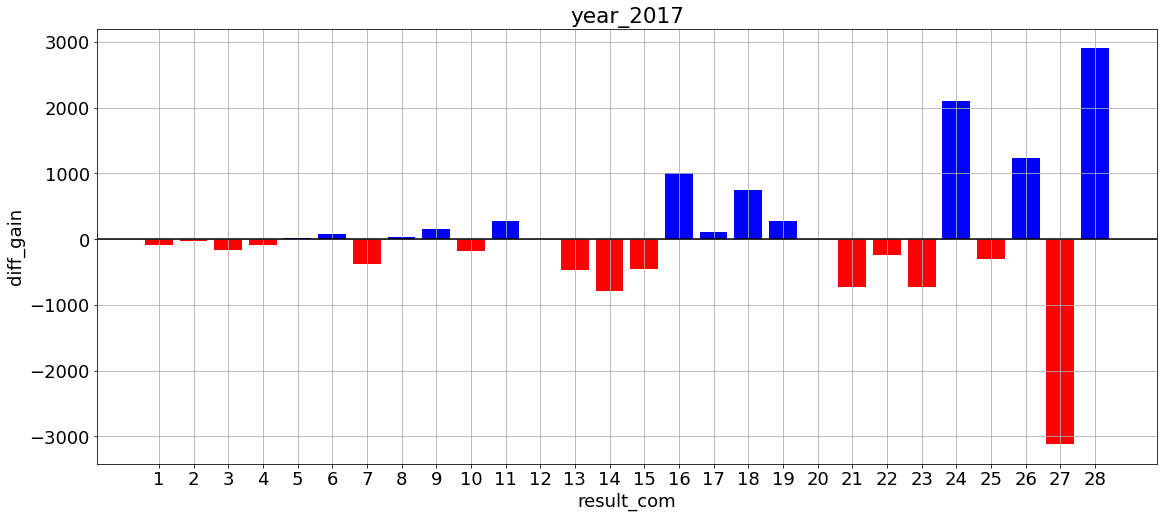

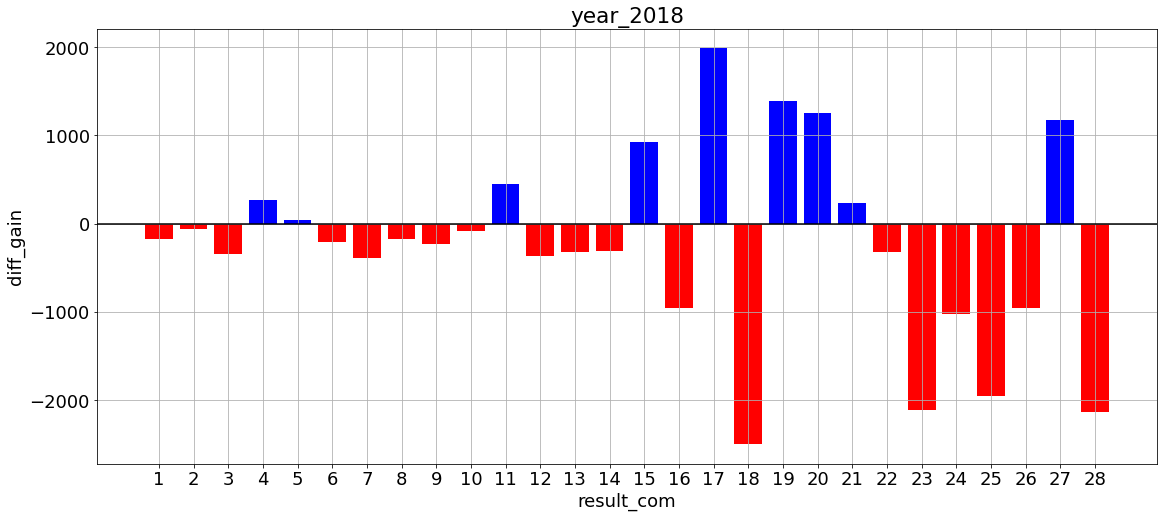

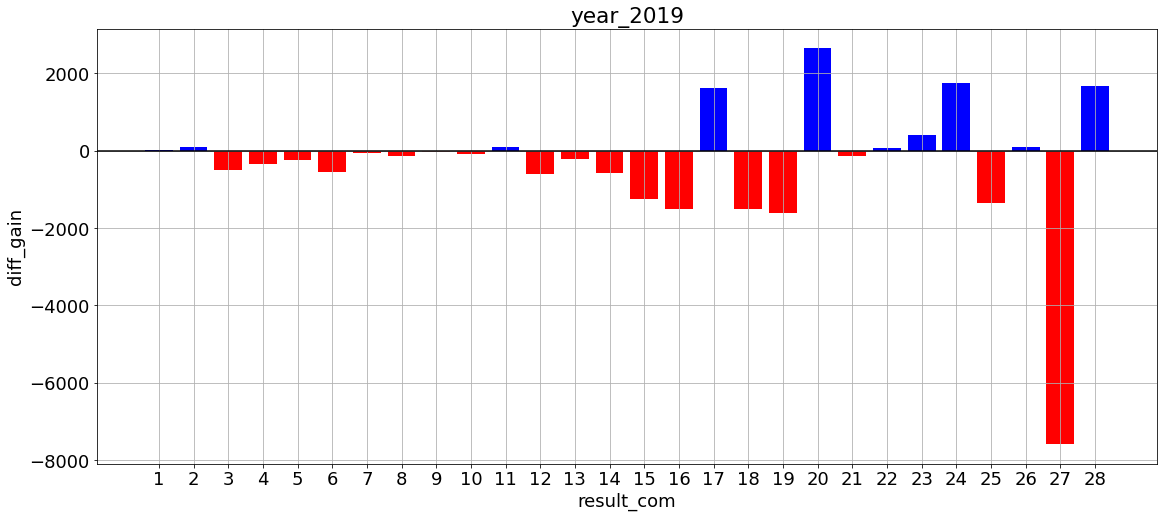

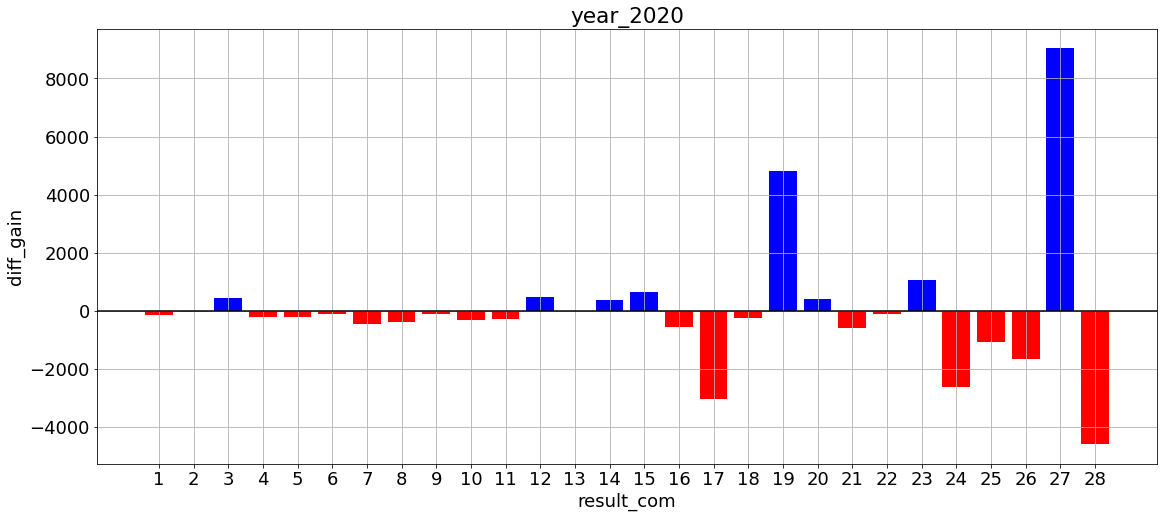

In [11]:
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv'.format(place_name=place_name)
train_df=pd.read_csv(dir_path, encoding='utf_8_sig')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
train_df=train_df[train_df['result_com']<=28].copy()#どうせ見ないレースは消す
train_df['date']=pd.to_datetime(train_df['date'])#日付が文字列なのでdateを日付型に変換
train_df['year']=train_df['date'].dt.year
train_df=train_df[train_df['year']!=2021]#2021年よりも前のデータに絞る

#年を行に，com列にした分析用のdfを作る.
gain_com_df=pd.DataFrame(columns=np.arange(1,29),dtype=int)
years_arr=sorted(train_df['year'].value_counts().index)
for year in years_arr:
    target_year_df=train_df[train_df['year']==year].copy()
    com_gains=list()
    print(year)
    for target_com in np.arange(1,29):
        target_year_com_df=target_year_df[target_year_df["result_com"]==target_com].copy()
        desc_year_com_df=target_year_com_df.describe().copy()
        com_gains.append(desc_year_com_df.at['mean','money'])
        #com_gains.append(target_year_com_df['money'].quantile(0.25))#厳しめ（上位75%の配当が入るように）

    year_s=pd.Series(index=np.arange(1,29),data=com_gains,dtype=float)
    gain_com_df.loc[year]=year_s
    
gain_desc_df=gain_com_df.describe()
diff_gain_df=gain_com_df.copy()

#desc_dfの統計量との差を確認する(mean)
for index,row in gain_com_df.iterrows():
    for key,val in row.items():
        diff_gain_df.at[index,key]=diff_gain_df.at[index,key]-gain_desc_df.at['mean',key]
        

# num_com_desc_df_2019_2020=num_com_df.loc[:2018].describe()#2019,2020を除いた党警鐘を算出
# diff_num_com_df_2019_2020=num_com_df.copy()
# #2019,2020を除いた，desc_dfの統計量との差を確認する(mean)
# for index,row in diff_num_com_df_2019_2020.iterrows():
#     for key,val in row.items():
#         diff_num_com_df_2019_2020.at[index,key]=diff_num_com_df_2019_2020.at[index,key]-num_com_desc_df_2019_2020.at['mean',key]
        
diff_gain_trans_df=diff_gain_df.transpose()#マットプロット用，行と列を入れ替えた
#diff_num_com_trans_df_2019_2020=diff_num_com_df_2019_2020.transpose()#マットプロット用，行と列を入れ替えた\

# num_com_df:年ごとの出現数をまとめたdf
# num_com_desc_df:全体を通しての統計量を持ったdf


#以下グラフの描画
for col in diff_num_com_trans_df.columns:
    #if col==2020 or col==2019:
    df_hist_cate_plt(diff_gain_trans_df,col,plt_ti="year_"+str(col),xlabel="result_com",ylabel="diff_gain")

# 最終comまで全部の収益の基準からの増減

2012
2013
2014
2015
2016
2017
2018
2019
2020


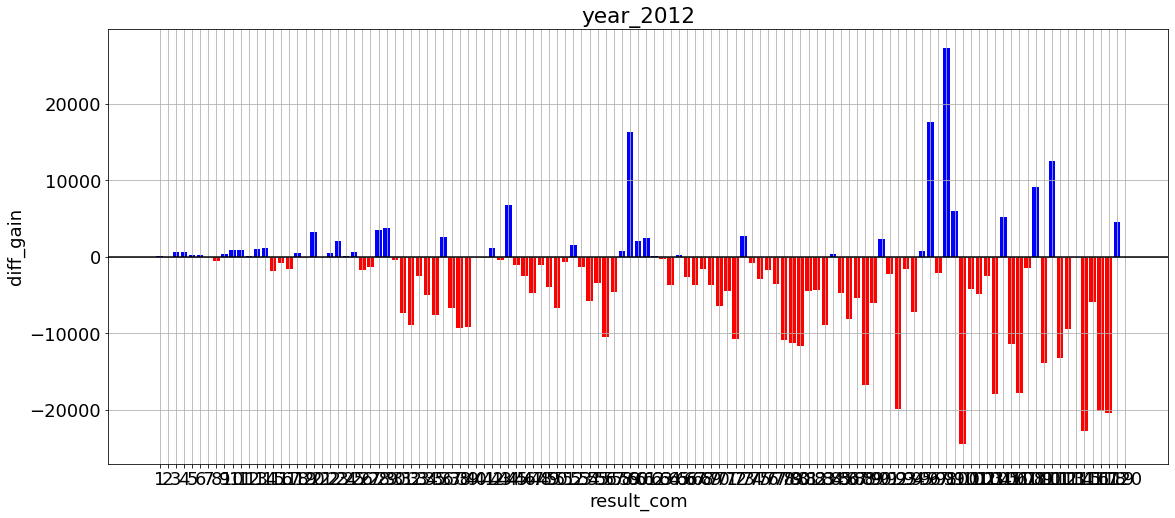

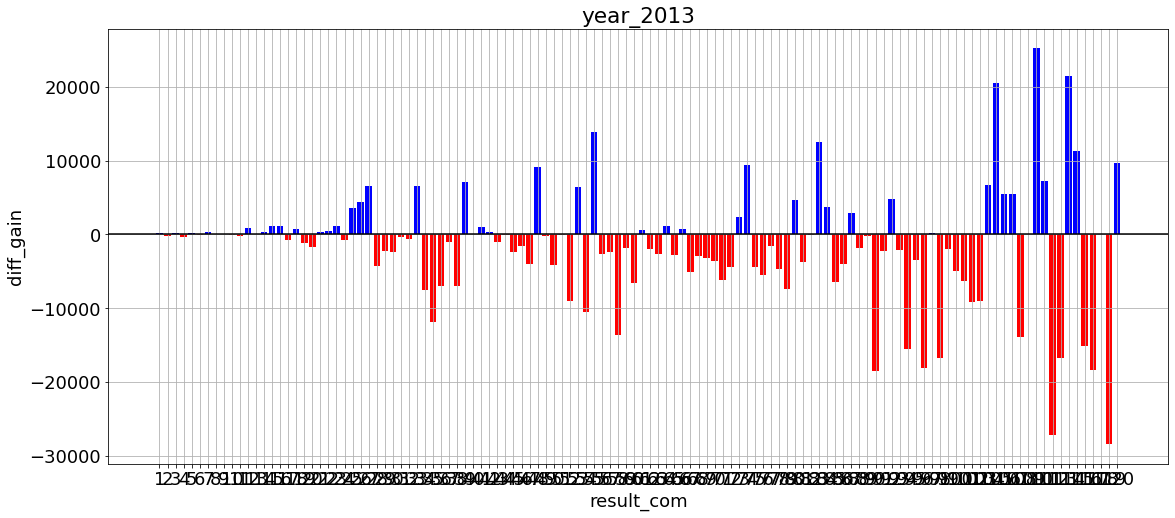

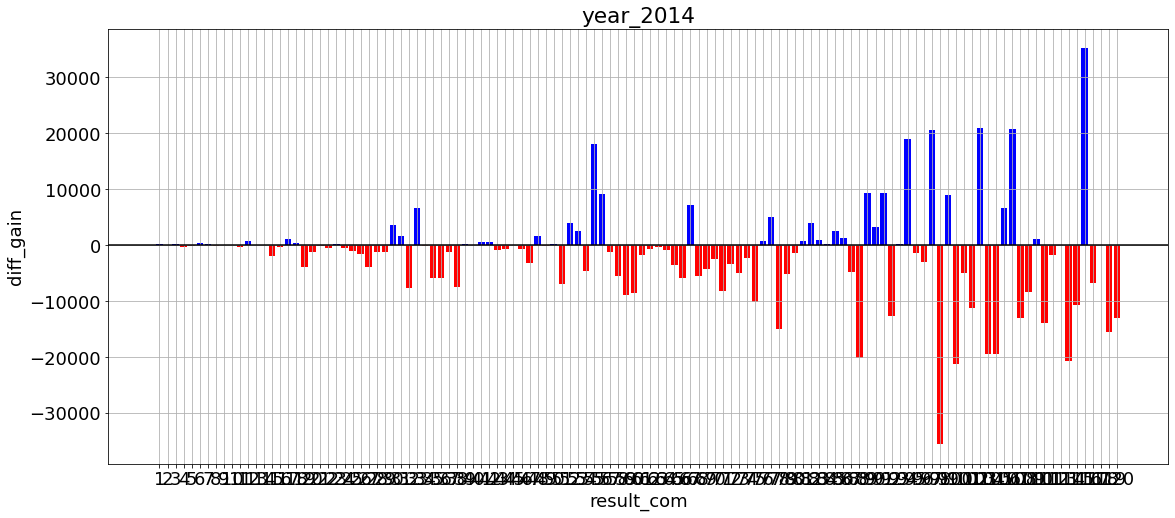

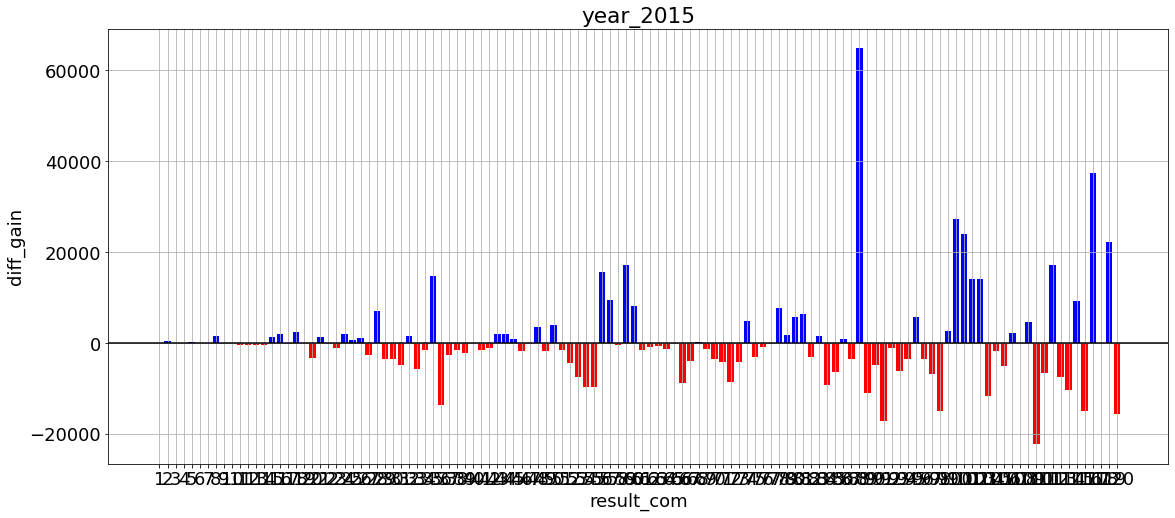

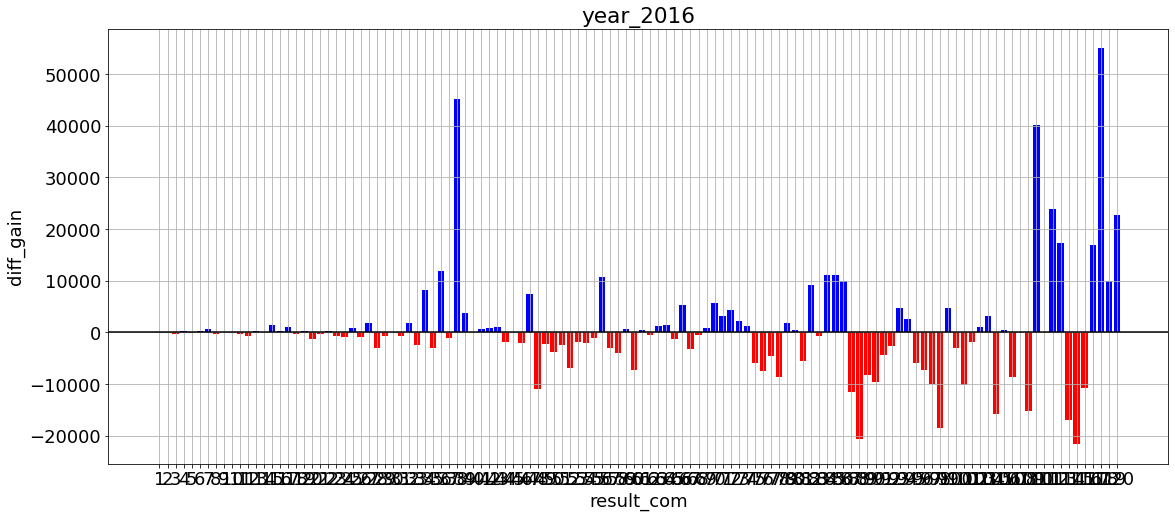

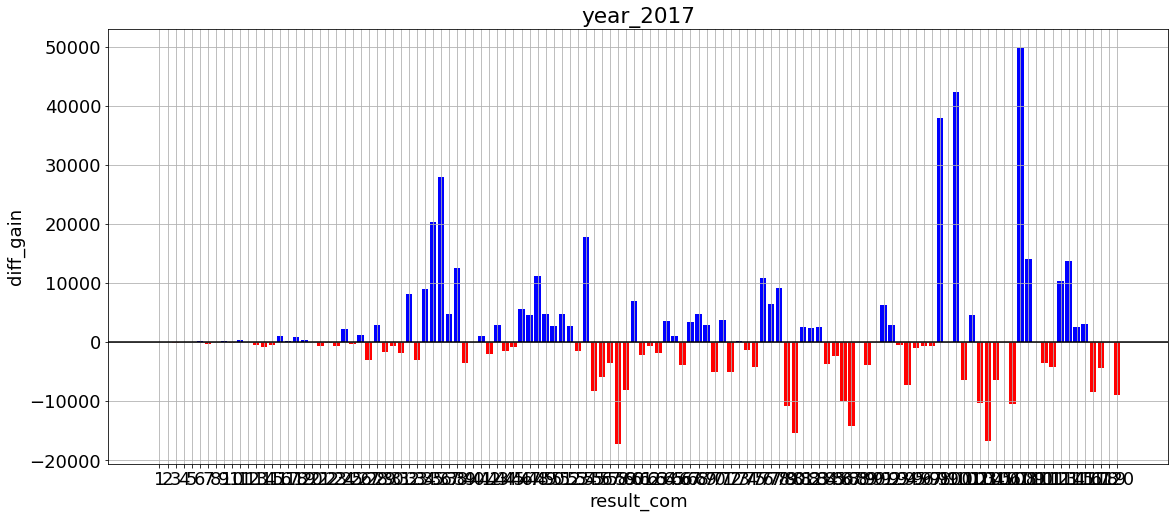

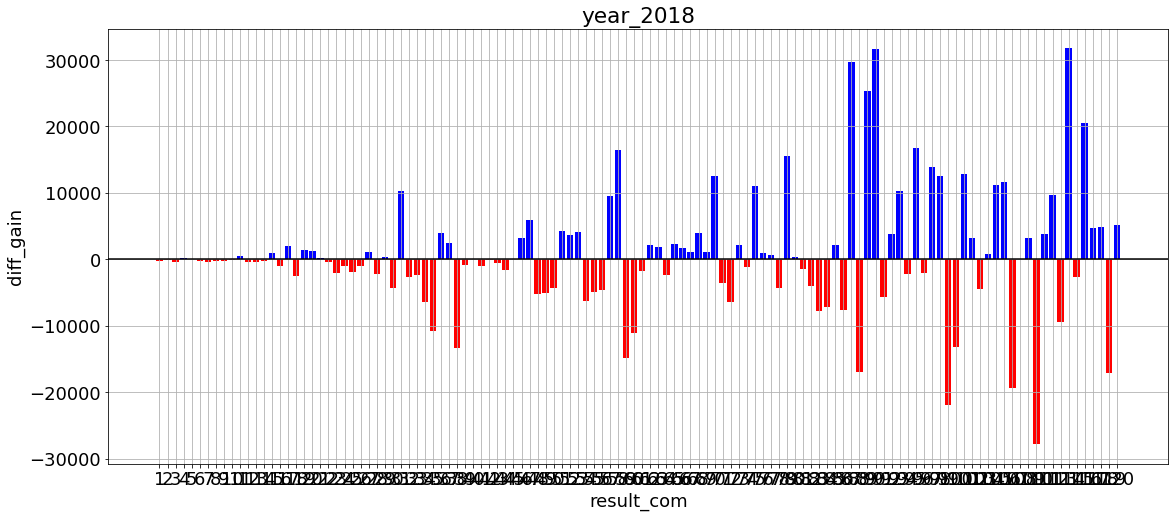

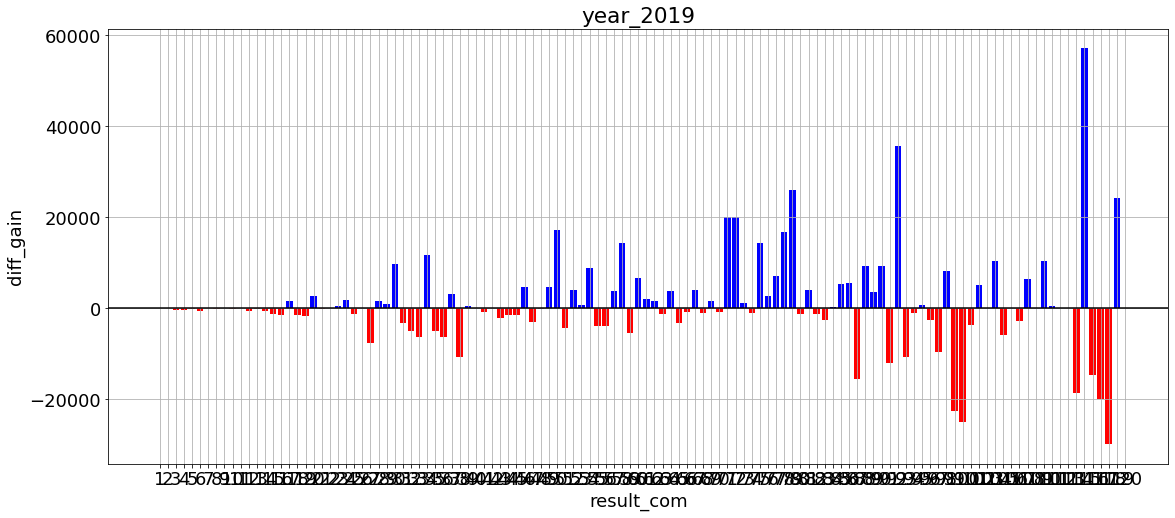

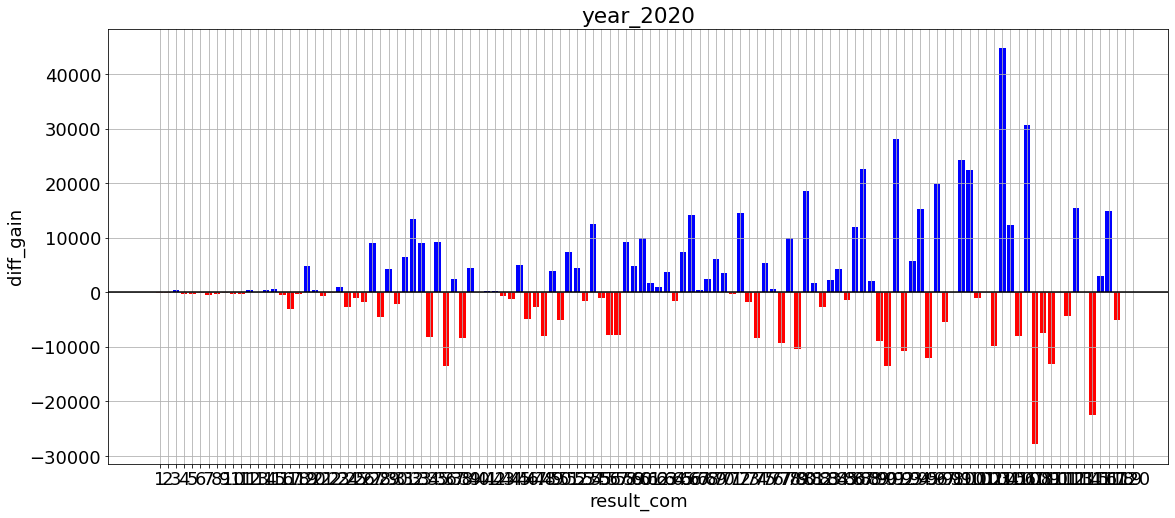

In [13]:
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv'.format(place_name=place_name)
train_df=pd.read_csv(dir_path, encoding='utf_8_sig')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
train_df['date']=pd.to_datetime(train_df['date'])#日付が文字列なのでdateを日付型に変換
train_df['year']=train_df['date'].dt.year
train_df=train_df[train_df['year']!=2021]#2021年よりも前のデータに絞る

#年を行に，com列にした分析用のdfを作る.
gain_com_df=pd.DataFrame(columns=np.arange(1,121),dtype=int)
years_arr=sorted(train_df['year'].value_counts().index)
for year in years_arr:
    target_year_df=train_df[train_df['year']==year].copy()
    com_gains=list()
    print(year)
    for target_com in np.arange(1,121):
        target_year_com_df=target_year_df[target_year_df["result_com"]==target_com].copy()
        desc_year_com_df=target_year_com_df.describe().copy()
        com_gains.append(desc_year_com_df.at['mean','money'])
        #com_gains.append(target_year_com_df['money'].quantile(0.25))#厳しめ（上位75%の配当が入るように）

    year_s=pd.Series(index=np.arange(1,121),data=com_gains,dtype=float)
    gain_com_df.loc[year]=year_s
    
gain_desc_df=gain_com_df.describe()
diff_gain_df=gain_com_df.copy()

#desc_dfの統計量との差を確認する(mean)
for index,row in gain_com_df.iterrows():
    for key,val in row.items():
        diff_gain_df.at[index,key]=diff_gain_df.at[index,key]-gain_desc_df.at['mean',key]
        

# num_com_desc_df_2019_2020=num_com_df.loc[:2018].describe()#2019,2020を除いた党警鐘を算出
# diff_num_com_df_2019_2020=num_com_df.copy()
# #2019,2020を除いた，desc_dfの統計量との差を確認する(mean)
# for index,row in diff_num_com_df_2019_2020.iterrows():
#     for key,val in row.items():
#         diff_num_com_df_2019_2020.at[index,key]=diff_num_com_df_2019_2020.at[index,key]-num_com_desc_df_2019_2020.at['mean',key]
        
diff_gain_trans_df=diff_gain_df.transpose()#マットプロット用，行と列を入れ替えた
#diff_num_com_trans_df_2019_2020=diff_num_com_df_2019_2020.transpose()#マットプロット用，行と列を入れ替えた\

# num_com_df:年ごとの出現数をまとめたdf
# num_com_desc_df:全体を通しての統計量を持ったdf


#以下グラフの描画
for col in diff_num_com_trans_df.columns:
    #if col==2020 or col==2019:
    df_hist_cate_plt(diff_gain_trans_df,col,plt_ti="year_"+str(col),xlabel="result_com",ylabel="diff_gain")

# 出現comに収益がプラスだったモデルの数を一緒に描画する

### 試しにversion v3_2

#### year=2019

<ipython-input-73-bb92aad50df8>:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


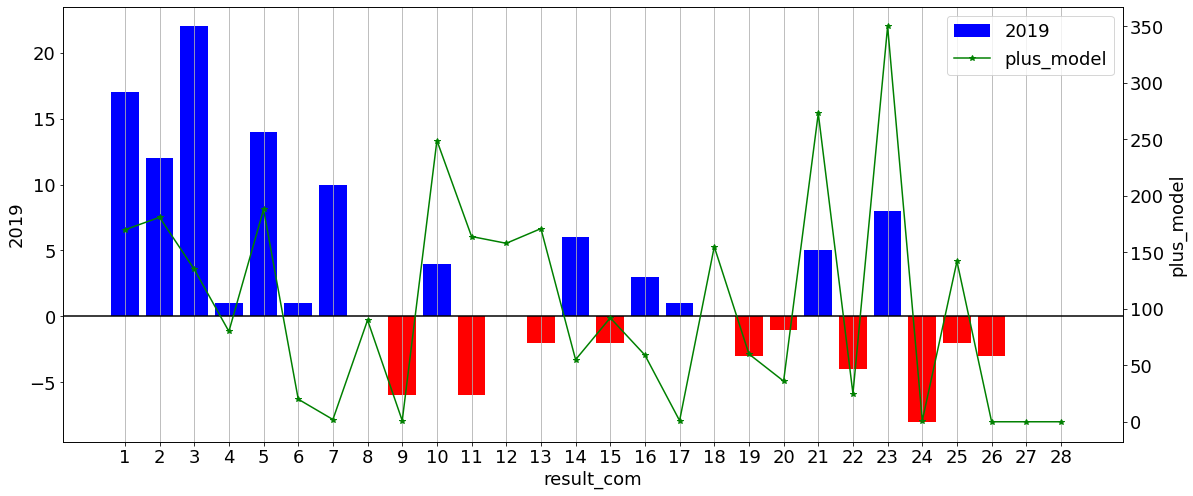

In [74]:
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv'.format(place_name=place_name)
train_df=pd.read_csv(dir_path, encoding='utf_8_sig')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
train_df=train_df[train_df['result_com']<=28].copy()#どうせ見ないレースは消す
train_df['date']=pd.to_datetime(train_df['date'])#日付が文字列なのでdateを日付型に変換
train_df['year']=train_df['date'].dt.year
train_df=train_df[train_df['year']!=2021]

#年を行に，comを列にした分析用のdfを作る.
num_com_df=pd.DataFrame(columns=np.arange(1,29),dtype=int)
years_arr=sorted(train_df['year'].value_counts().index)
for year in years_arr:
    target_df=train_df[train_df['year']==year].copy()
    
    com_count=target_df['result_com'].value_counts(sort=False)
    year_s=pd.Series(index=np.arange(1,29),data=com_count.values,dtype=int)
    num_com_df.loc[year]=year_s
num_com_desc_df=num_com_df.describe()
diff_num_com_df=num_com_df.copy()

#desc_dfの統計量との差を確認する(mean)
for index,row in num_com_df.iterrows():
    for key,val in row.items():
        diff_num_com_df.at[index,key]=diff_num_com_df.at[index,key]-num_com_desc_df.at['mean',key]

        
        
#v3_２のモデリング結果と比較して，出現数と収益の増減が連動しているかを確認する====================================================================
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/model_score_{place_name}/{place_name}_model_score_V3_2.csv'.format(place_name=place_name)
model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
plus_model_year_df=model_score_df[model_score_df['gain_year1']>100].copy()#大体三割いかないくらい
plus_model_com=pd.Series(dict(sorted(plus_model_year_df['target_com'].value_counts().items())))








diff_num_com_trans_df=diff_num_com_df.transpose()#マットプロット用，行と列を入れ替えた
diff_num_com_trans_df["plus_model"]=plus_model_com
diff_num_com_trans_df["result_com"]=diff_num_com_trans_df.index

diff_num_com_trans_df=diff_num_com_trans_df.fillna(0)
#num_com_df:年ごとの出現数をまとめたdf
#num_com_desc_df:全体を通しての統計量を持ったdf
#以下グラフの描画
x=diff_num_com_df.loc[2019].index
y1=diff_num_com_df.loc[2019].values
y2=plus_model_com_val
x_n='result_com'
y1_n=2019
y2_n='plus_model'

df_bar_twin_plt(diff_num_com_trans_df,x_n,y1_n,y2_n)


<ipython-input-73-bb92aad50df8>:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


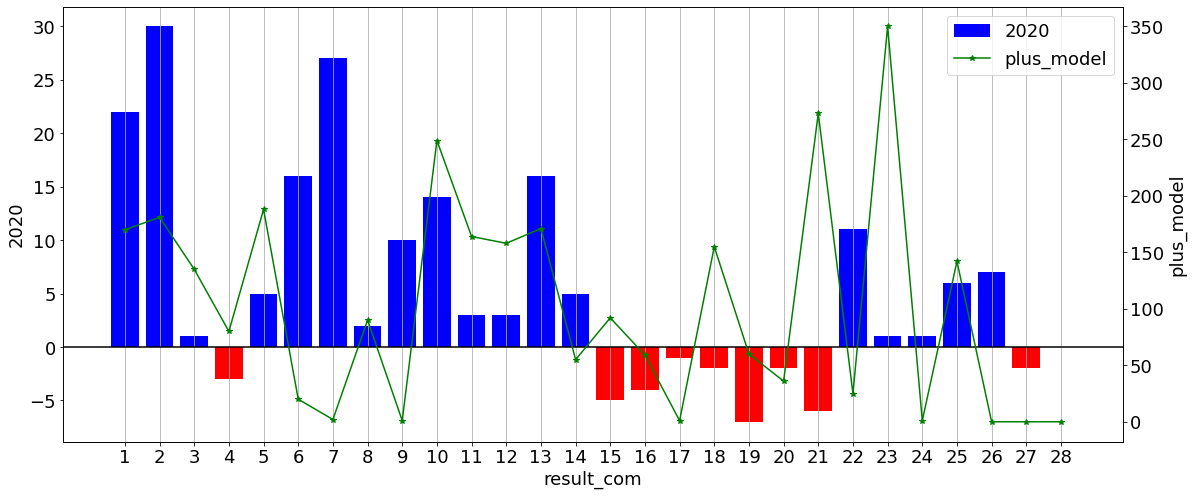

In [75]:
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/{place_name}_train/train_{place_name}.csv'.format(place_name=place_name)
train_df=pd.read_csv(dir_path, encoding='utf_8_sig')
train_df=train_df.drop(["Unnamed: 0"],axis=1)
train_df=train_df[train_df['result_com']<=28].copy()#どうせ見ないレースは消す
train_df['date']=pd.to_datetime(train_df['date'])#日付が文字列なのでdateを日付型に変換
train_df['year']=train_df['date'].dt.year
train_df=train_df[train_df['year']!=2021]
train_df=train_df[train_df['year']>2015]
#年を行に，comを列にした分析用のdfを作る.
num_com_df=pd.DataFrame(columns=np.arange(1,29),dtype=int)
years_arr=sorted(train_df['year'].value_counts().index)
for year in years_arr:
    target_df=train_df[train_df['year']==year].copy()
    
    com_count=target_df['result_com'].value_counts(sort=False)
    year_s=pd.Series(index=np.arange(1,29),data=com_count.values,dtype=int)
    num_com_df.loc[year]=year_s
num_com_desc_df=num_com_df.describe()
diff_num_com_df=num_com_df.copy()

#desc_dfの統計量との差を確認する(mean)
for index,row in num_com_df.iterrows():
    for key,val in row.items():
        diff_num_com_df.at[index,key]=diff_num_com_df.at[index,key]-num_com_desc_df.at['mean',key]

        
        
#v3_２のモデリング結果と比較して，出現数と収益の増減が連動しているかを確認する====================================================================
place_name="asiya"
#for place_name in place_names[:10]:
dir_path='../../bot_database/{place_name}/model_score_{place_name}/{place_name}_model_score_V3_2.csv'.format(place_name=place_name)
model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
plus_model_year_df=model_score_df[model_score_df['gain_year1']>100].copy()#大体三割いかないくらい
plus_model_com=pd.Series(dict(sorted(plus_model_year_df['target_com'].value_counts().items())))








diff_num_com_trans_df=diff_num_com_df.transpose()#マットプロット用，行と列を入れ替えた
diff_num_com_trans_df["plus_model"]=plus_model_com
diff_num_com_trans_df["result_com"]=diff_num_com_trans_df.index

diff_num_com_trans_df=diff_num_com_trans_df.fillna(0)
#num_com_df:年ごとの出現数をまとめたdf
#num_com_desc_df:全体を通しての統計量を持ったdf
#以下グラフの描画
x=diff_num_com_df.loc[2020].index
y1=diff_num_com_df.loc[2020].values
y2=plus_model_com_val
x_n='result_com'
y1_n=2020
y2_n='plus_model'

df_bar_twin_plt(diff_num_com_trans_df,x_n,y1_n,y2_n)


In [30]:
plus_model_com[1][0]

2.0

In [45]:
plus_model_com

{1.0: 170,
 2.0: 181,
 3.0: 135,
 4.0: 80,
 5.0: 188,
 6.0: 20,
 7.0: 2,
 8.0: 90,
 9.0: 1,
 10.0: 249,
 11.0: 164,
 12.0: 158,
 13.0: 171,
 14.0: 55,
 15.0: 92,
 16.0: 59,
 17.0: 1,
 18.0: 155,
 19.0: 60,
 20.0: 36,
 21.0: 273,
 22.0: 25,
 23.0: 350,
 24.0: 1,
 25.0: 142}

In [41]:
def twin_plt(x,y1,y2,ylims=None,plt_ti=None,xlabel=None,ylabel=None):#2本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    fig.set_facecolor(color='white')
    
    
    ax1 = fig.add_subplot()
    #ax1.plot(x, y1,label=y1_n, marker="o")
    ax1.bar(x, y1)

    ax1.tick_params()
    ax2 = ax1.twinx()
    #ax2.plot(x, y2,label=y2_n,color='red', marker="*")
    ax2.plot(x, y2,color='red', marker="*")
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2)
    
    
    if ylims!=None:
        ax.set_ylim(ylims[0],ylims[1])
    if xlabel!=None:
        ax.set_xlabel(xlabel)
    if ylabel!=None:
        ax.set_ylabel(ylabel)
    if plt_ti!=None:
        ax.set_title(plt_ti)
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None


In [148]:
target_year_com_df['money'].std()

2708.0023875129145

In [149]:
target_year_com_df.describe()

,result_com,money,number_race,racer_1_ID,racer_2_ID,racer_3_ID,racer_4_ID,racer_5_ID,racer_6_ID,racer_1_rank,...,racer_2_mo,racer_3_bo,racer_3_mo,racer_4_bo,racer_4_mo,racer_5_bo,racer_5_mo,racer_6_bo,racer_6_mo,year
count,110.0,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,...,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.0
mean,6.0,1847.636364,6.390909,4022.172727,3855.072727,3938.045455,4087.727273,4041.572727,4234.936364,3.436364,...,39.818182,31.709091,41.645455,33.763636,40.072727,30.690909,44.590909,30.490909,40.763636,2016.0
std,0.0,2708.002388,3.719760,417.756961,541.632966,488.633545,505.914032,569.006304,507.333039,0.748421,...,18.384368,17.221890,16.269850,15.403400,17.723001,17.692970,18.234605,18.221242,18.780689,0.0
min,6.0,350.000000,1.000000,2878.000000,2505.000000,2887.000000,2816.000000,2776.000000,2903.000000,2.000000,...,11.000000,1.000000,11.000000,2.000000,11.000000,2.000000,11.000000,1.000000,11.000000,2016.0
25%,6.0,887.500000,3.000000,3753.250000,3488.500000,3586.000000,3646.000000,3660.000000,3912.500000,3.000000,...,24.000000,17.000000,28.000000,24.000000,24.250000,14.250000,30.250000,17.250000,22.000000,2016.0
50%,6.0,1265.000000,7.000000,4077.000000,3845.000000,4004.500000,4187.000000,4082.500000,4334.500000,4.000000,...,42.000000,30.000000,42.500000,34.000000,36.000000,29.500000,47.000000,30.000000,41.500000,2016.0
75%,6.0,1880.000000,10.000000,4347.500000,4338.250000,4271.750000,4498.750000,4591.000000,4662.250000,4.000000,...,53.000000,47.750000,54.750000,48.000000,55.000000,45.750000,61.000000,45.750000,56.750000,2016.0
max,6.0,26590.000000,12.000000,4831.000000,4831.000000,4848.000000,4857.000000,4913.000000,4952.000000,4.000000,...,75.000000,63.000000,71.000000,61.000000,75.000000,63.000000,73.000000,65.000000,75.000000,2016.0


In [138]:
target_com

2